In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Import python modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

matplotlib.rc("figure", figsize=(10, 8))
matplotlib.rc("font", size=12)
colors = cm.tab10(np.linspace(0, 1, 10))

### Dataset

In [3]:
df = pd.read_csv("data/aircraft.csv", index_col=0)

train_acs = "A320,A321,A343,A359,B734,B737,B748,B752,B763,B77W,B788,B789,C550,E145,E190"
train_acs = train_acs.split(",")

df_train = df.query("index in @train_acs")
df_test = df.query("index not in @train_acs")

x_train = df_train.length.values
y_train = df_train.max_weight.values

x_test = df_test.length.values
y_test = df_test.max_weight.values

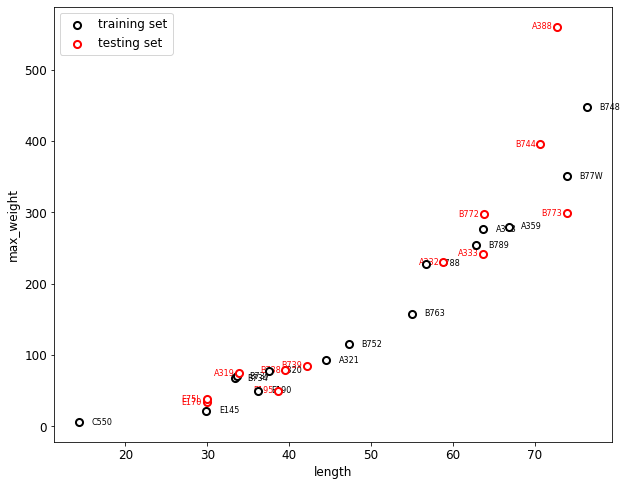

In [4]:
from common import plot_data, plot_poly

fig, ax = plt.subplots(1)
plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True, show_type=True)

# Experimenting with different polynomials

With the following code, let us experiment with a number of different polynomial models.

In [5]:
from ipywidgets import interact

@interact(k=(0, 13))
def double_number(k):
    fig, ax = plt.subplots(1)
    coef_np = np.polyfit(x_train, y_train, k)
    coef = coef_np[::-1]
    model = np.poly1d(coef_np)
    plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True)
    plot_poly(ax, x_train, coef, color=colors[k%10])    
    ax.set_ylim([-200, 700])
    ax.legend(loc="lower center")
    ax.set_title("k={}".format(k))
    plt.show()

interactive(children=(IntSlider(value=6, description='k', max=13), Output()), _dom_classes=('widget-interact',…

## Comparing all polynomial model together

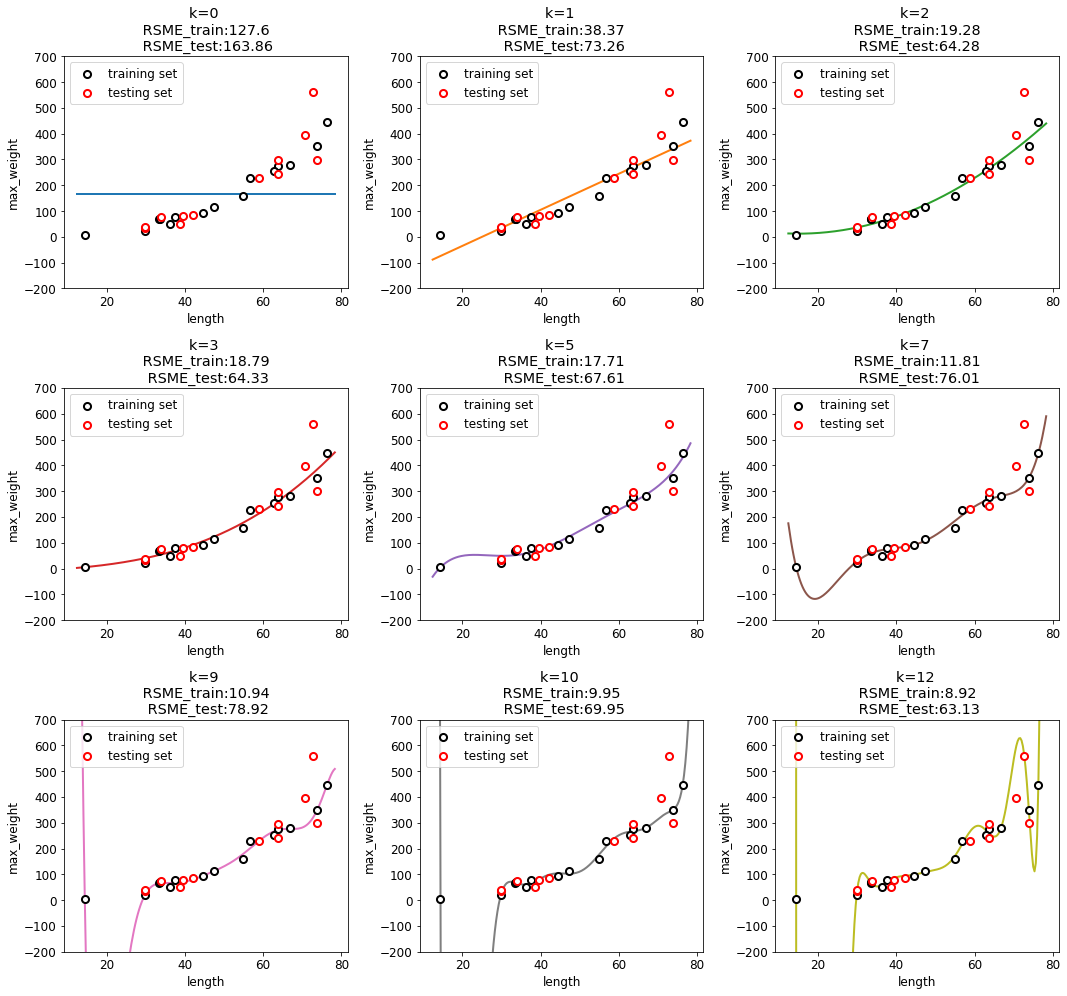

In [6]:
from sklearn.metrics import mean_squared_error

ks = [0, 1, 2, 3, 5, 7, 9, 10, 12]
fig, axes = plt.subplots(3, 3, figsize=(15, 14))

for i, k in enumerate(ks):
    ax = axes.flatten()[i]

    coef_np = np.polyfit(x_train, y_train, k)
    coef = coef_np[::-1]
    model = np.poly1d(coef_np)

    RSME_train = np.sqrt(mean_squared_error(y_train, model(x_train))).round(2)
    RSME_test = np.sqrt(mean_squared_error(y_test, model(x_test))).round(2)

    plot_data(ax, df_train, df_test, xcol="length", ycol="max_weight", show_test=True)
    plot_poly(ax, x_train, coef, color=colors[i])
    ax.set_ylim([-200, 700])
    ax.set_title('k={} \n RSME_train:{} \n RSME_test:{}'.format(k, RSME_train, RSME_test))
    ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

## ❗Important points to note ❗:

---

1. With the increasing polynomial orders, the RMSE on the training data is decrease. 
    - This means our model gets better and better at fitting with the training data. 
1. By looking at the test data, we see the best order is when k=2 or k=3. 
1. When k=1, the model is not able to capture the non-linearity in the data. In this case the model has a **high bias** and **under fits** the data.
1. When k>=5, the models have **high variability** and are less biased than k<=3. But they **over fit** the training data.

## Coefficients of the polynomial models

In [7]:
x_ = np.linspace(min(x_train), max(x_train), 100)

ks = [0, 1, 2, 3, 5, 7, 10, 12, 13]

for i, k in enumerate(ks):

    coef_np = np.polyfit(x_train, y_train, k)

    model = np.poly1d(coef_np)
    print('-' * 100)
    print("k={}".format(k))
    print(model)


----------------------------------------------------------------------------------------------------
k=0
 
166.4
----------------------------------------------------------------------------------------------------
k=1
 
6.994 x - 174.9
----------------------------------------------------------------------------------------------------
k=2
        2
0.1066 x - 3.2 x + 36.39
----------------------------------------------------------------------------------------------------
k=3
           3            2
0.0007341 x + 0.007055 x + 0.8282 x - 10.36
----------------------------------------------------------------------------------------------------
k=5
           5            4          3         2
7.706e-06 x - 0.001782 x + 0.1568 x - 6.381 x + 120.7 x - 806.1
----------------------------------------------------------------------------------------------------
k=7
           7             6             5           4         3
1.755e-09 x + 6.873e-07 x - 0.0002744 x + 0.03374 x - 2.008 x
   

---

🔴**IMPORTANT**🔴: Coefficient become very large (up to $10^8$) in over fitted models

---

# Why some coefficients become so large?

Recall our model in matrix format:

$$
\begin{bmatrix}
1 & x_1 & x_1^2 & \dots & x_1^k\\
1 & x_2 & x_2^2 & \dots & x_2^k\\
\vdots & \vdots & \vdots & \ddots & \vdots\\
1 & x_N & x_N^2 & \dots & x_N^k
\end{bmatrix}
\begin{bmatrix}
\beta_0 \\ \beta_1 \\ \vdots \\ \beta_k
\end{bmatrix}
=
\begin{bmatrix}
y_0 \\ y_1 \\ \vdots \\ y_N
\end{bmatrix}
$$

$$
\mathbf{X} \mathbf{\beta} = \mathbf{y}
$$

$$
\hat \beta = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} \\
$$

Let's have a look at $\mathbf{X}$

$$
\mathbf{X}_i = [1, x_i, x_i^2, \cdots, x_i^k]
$$

In [8]:
x = x_train[x_train.argsort()]
y = y_train[x_train.argsort()]

X = np.vander(x, 12+1, increasing=True)
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,14.39,207.0721,2979.767519,4.287885e+04,6.170267e+05,8.879014e+06,1.277690e+08,1.838596e+09,2.645740e+10,3.807220e+11,5.478589e+12,7.883690e+13
1,1.0,29.87,892.2169,26650.518803,7.960510e+05,2.377804e+07,7.102502e+08,2.121517e+10,6.336972e+11,1.892854e+13,5.653953e+14,1.688836e+16,5.044553e+17
2,1.0,33.40,1115.5600,37259.704000,1.244474e+06,4.156544e+07,1.388286e+09,4.636874e+10,1.548716e+12,5.172711e+13,1.727685e+15,5.770469e+16,1.927337e+18
3,1.0,33.60,1128.9600,37933.056000,1.274551e+06,4.282490e+07,1.438917e+09,4.834760e+10,1.624479e+12,5.458251e+13,1.833972e+15,6.162147e+16,2.070481e+18
4,1.0,36.24,1313.3376,47595.354624,1.724856e+06,6.250877e+07,2.265318e+09,8.209512e+10,2.975127e+12,1.078186e+14,3.907346e+15,1.416022e+17,5.131665e+18
5,1.0,37.57,1411.5049,53030.239093,1.992346e+06,7.485244e+07,2.812206e+09,1.056546e+11,3.969443e+12,1.491320e+14,5.602888e+15,2.105005e+17,7.908504e+18
6,1.0,44.51,1981.1401,88180.545851,3.924916e+06,1.746980e+08,7.775809e+09,3.461012e+11,1.540497e+13,6.856751e+14,3.051940e+16,1.358418e+18,6.046320e+19
7,1.0,47.30,2237.2900,105823.817000,5.005467e+06,2.367586e+08,1.119868e+10,5.296976e+11,2.505470e+13,1.185087e+15,5.605462e+16,2.651383e+18,1.254104e+20
8,1.0,54.94,3018.4036,165831.093784,9.110760e+06,5.005452e+08,2.749995e+10,1.510847e+12,8.300595e+13,4.560347e+15,2.505455e+17,1.376497e+19,7.562473e+20
9,1.0,56.72,3217.1584,182477.224448,1.035011e+07,5.870581e+08,3.329794e+10,1.888659e+12,1.071247e+14,6.076115e+15,3.446373e+17,1.954783e+19,1.108753e+21


Let's look at: $\mathbf{X}^T \mathbf{X}$

In [9]:
pd.DataFrame(np.dot(X.T, X))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.500000e+01,7.320000e+02,4.026339e+04,2.399107e+06,1.510487e+08,9.884910e+09,6.650539e+11,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22
1,7.320000e+02,4.026339e+04,2.399107e+06,1.510487e+08,9.884910e+09,6.650539e+11,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24
2,4.026339e+04,2.399107e+06,1.510487e+08,9.884910e+09,6.650539e+11,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26
3,2.399107e+06,1.510487e+08,9.884910e+09,6.650539e+11,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26,3.269874e+28
4,1.510487e+08,9.884910e+09,6.650539e+11,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26,3.269874e+28,2.412302e+30
5,9.884910e+09,6.650539e+11,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26,3.269874e+28,2.412302e+30,1.785366e+32
6,6.650539e+11,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26,3.269874e+28,2.412302e+30,1.785366e+32,1.325056e+34
7,4.566792e+13,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26,3.269874e+28,2.412302e+30,1.785366e+32,1.325056e+34,9.858162e+35
8,3.185145e+15,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26,3.269874e+28,2.412302e+30,1.785366e+32,1.325056e+34,9.858162e+35,7.349845e+37
9,2.248921e+17,1.603729e+19,1.153061e+21,8.347675e+22,6.078802e+24,4.448784e+26,3.269874e+28,2.412302e+30,1.785366e+32,1.325056e+34,9.858162e+35,7.349845e+37,5.489918e+39


Let's look at: $(\mathbf{X}^T \mathbf{X})^{-1}$:

In [10]:
from scipy.linalg import inv
pd.DataFrame(inv(np.dot(X.T, X)))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.137175e+08,-3.469382e+07,4.525799e+06,-3.308128e+05,1.482427e+04,-4.113070e+02,6.361780e+00,-1.944257e-02,-1.321646e-03,2.944763e-05,-3.027898e-07,1.615624e-09,-3.608740e-12
1,-2.770177e+07,8.403251e+06,-1.090306e+06,7.929610e+04,-3.536669e+03,9.767947e+01,-1.503199e+00,4.501191e-03,3.125292e-04,-6.928173e-06,7.101080e-08,-3.779133e-10,8.422178e-13
2,2.913399e+06,-8.729081e+05,1.119914e+05,-8.063294e+03,3.563662e+02,-9.758110e+00,1.487335e-01,-4.261299e-04,-3.106161e-05,6.820059e-07,-6.951288e-09,3.683169e-11,-8.177699e-14
3,-1.787989e+05,5.233660e+04,-6.572705e+03,4.642592e+02,-2.016669e+01,5.432244e-01,-8.125286e-03,2.101574e-05,1.720627e-06,-3.706976e-08,3.738801e-10,-1.965132e-12,4.333925e-15
4,7.352392e+03,-2.071408e+03,2.507772e+02,-1.711877e+01,7.201986e-01,-1.879665e-02,2.704780e-04,-5.291259e-07,-5.946903e-08,1.231755e-09,-1.215825e-11,6.286285e-14,-1.367504e-16
5,-2.228743e+02,5.964819e+01,-6.845727e+00,4.427631e-01,-1.763404e-02,4.338219e-04,-5.750914e-06,2.579192e-09,1.391715e-09,-2.653115e-11,2.496654e-13,-1.243108e-15,2.617765e-18
6,5.346821e+00,-1.362333e+00,1.477537e-01,-8.965785e-03,3.318758e-04,-7.451235e-06,8.429108e-08,2.567684e-10,-2.519068e-11,4.137527e-13,-3.525098e-15,1.607520e-17,-3.111459e-20
7,-1.043992e-01,2.596193e-02,-2.731829e-03,1.596558e-04,-5.628665e-06,1.175748e-07,-1.121882e-09,-8.843617e-12,4.348842e-13,-6.282311e-15,4.836277e-17,-1.984743e-19,3.403228e-22
8,1.612643e-03,-4.040050e-04,4.290306e-05,-2.535458e-06,9.060256e-08,-1.924572e-09,1.881733e-11,1.464954e-13,-7.524812e-15,1.124514e-16,-9.008123e-19,3.883518e-21,-7.092469e-24
9,-1.842958e-05,4.741703e-06,-5.199824e-07,3.192474e-08,-1.194999e-09,2.701649e-11,-2.998554e-13,-1.402608e-15,1.058969e-16,-1.744240e-18,1.515035e-20,-7.087538e-23,1.412927e-25


Eigenvalues of $(\mathbf{X}^T \mathbf{X})^{-1}$:

In [11]:
pd.DataFrame((np.linalg.eig(inv(np.dot(X.T, X)))[0])).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.222818e+08,-48733.450303,66.505944,-0.001832,7.434824e-07,2.262982e-10,3.630291e-14,1.725080e-23,7.629661e-19,2.508516e-28,1.300353e-33,1.013736e-38,2.170859e-44


Then let's look at: $\mathbf{X}^T \mathbf{y}$:

In [12]:
pd.DataFrame(np.dot(X.T, y)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2496.0,153567.89,9.891633e+06,6.581752e+08,4.483874e+10,3.109154e+12,2.185697e+14,1.553488e+16,1.114139e+18,8.050794e+19,5.854640e+21,4.280711e+23,3.144486e+25


# Choose the right polynomial order

You can use **Grid Search** + **Cross Validation** to choose the right polynomial order.

<br>

Supervised machine learning flow:

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width=600px />

### 🚨 **K-fold Cross validation** 🚨


<br>

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=800px style="margin-left: 200px"/>


# Demonstration of grid search + cross validation

In [13]:
def true_model(x):
    return np.sin (x) + np.sin (2 * x)

np.random.seed(0)
n = 100
x2 = 2 * np.pi * np.random.rand(n)
x2_ = np.linspace(0, 6.3, 100)
y2 = true_model(x2) + 0.2 * np.random.randn(n)

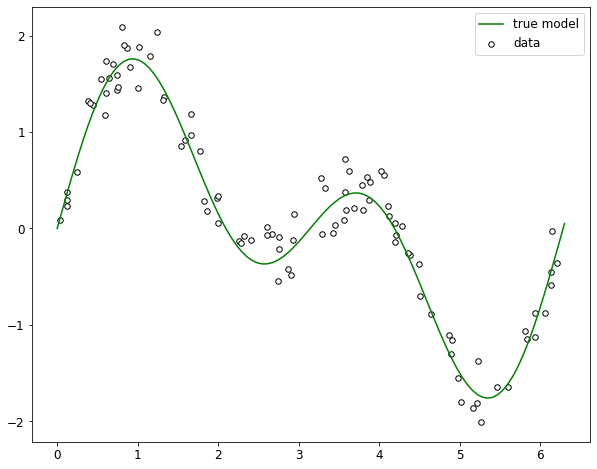

In [14]:
plt.scatter(x2, y2, s=30, facecolor='w', color='k', label='data')
plt.plot(x2_, true_model(x2_), color='g', label='true model')
plt.legend()

### Implementation using scikit-learn

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

pipe = Pipeline([
   ('poly', PolynomialFeatures()),
   ('linreg', LinearRegression())
])

parameters = {'poly__degree': range(0, 20)}

cv = GridSearchCV(pipe, parameters)

#### 🔴IMPORTANT🔴: The training data must be randomly shuffled.

In [16]:
shuffle = list(range(n))
np.random.seed(0)
np.random.shuffle(shuffle)

cv.fit(x2[shuffle].reshape(-1,1), y2[shuffle])

GridSearchCV(estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('linreg', LinearRegression())]),
             param_grid={'poly__degree': range(0, 20)})

In [17]:
cv.best_estimator_

Pipeline(steps=[('poly', PolynomialFeatures(degree=9)),
                ('linreg', LinearRegression())])

In [18]:
# default score for LinearRegression is R^2
cv.best_score_

0.9476859000845417

In [19]:
cv.cv_results_

{'mean_fit_time': array([0.00081391, 0.00091281, 0.0007802 , 0.00071926, 0.00055418,
        0.00066805, 0.00060053, 0.00059304, 0.00059042, 0.00058746,
        0.00060906, 0.00059872, 0.00061951, 0.00061541, 0.00062084,
        0.00063896, 0.00064607, 0.00065522, 0.00066209, 0.00066786]),
 'std_fit_time': array([1.67510281e-04, 2.27221217e-04, 2.00366928e-04, 9.18634427e-05,
        4.36664132e-06, 8.67478063e-05, 2.05734098e-05, 3.94031984e-05,
        3.18852561e-05, 1.12203745e-05, 2.72305331e-05, 1.04027029e-05,
        1.80151073e-05, 1.01795520e-05, 8.92080638e-07, 1.37615237e-05,
        1.25322022e-05, 1.68205279e-05, 5.92315441e-06, 8.11800382e-06]),
 'mean_score_time': array([0.00046506, 0.00042725, 0.00039091, 0.00043225, 0.00033865,
        0.00036259, 0.00033407, 0.0003335 , 0.00033188, 0.00033894,
        0.00034661, 0.00034451, 0.00035262, 0.00034928, 0.00036707,
        0.00036135, 0.0003593 , 0.00036626, 0.00036888, 0.0003664 ]),
 'std_score_time': array([4.30683481e-

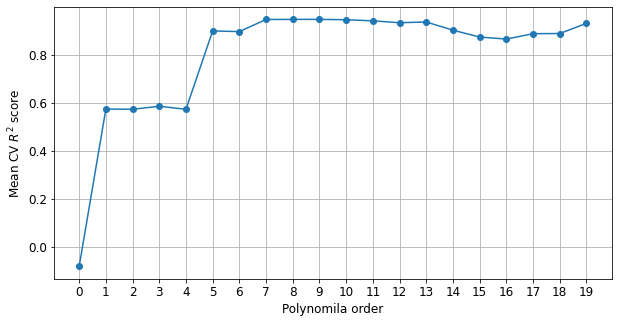

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(range(20), cv.cv_results_['mean_test_score'], 'o-')
plt.xticks(range(20))
plt.xlabel('Polynomila order')
plt.ylabel('Mean CV $R^2$ score ')
plt.grid()

## Visualize the "Goldilocks model"

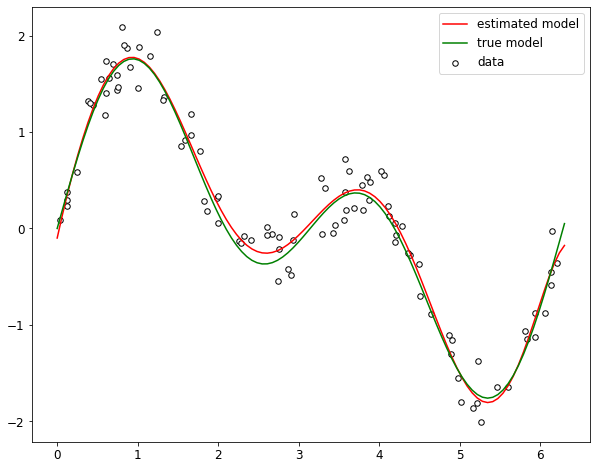

In [21]:
y2_hat = cv.best_estimator_.predict(x2_.reshape(-1,1))

plt.scatter(x2, y2, s=30, facecolor='w', color='k', label="data")
plt.plot(x2_, y2_hat, color='r', label="estimated model")
plt.plot(x2_, true_model(x2_), color='g', label="true model")
plt.legend()